# Distributed Coffea Jobs at UW Analysis Facility

This notebook demonstrates how one can run a full coffea analysis with Condor jobs on the Analysis Facility's cluster. As with the other notebooks, you should have already run your `voms-proxy-init` command in a terminal window before running anything here, as this example does access files remotely with XRootD.

As of February 2025, this notebook can also be used as a template for many coffea version >= v2023 analyses. This template should at least get an analysis up and running with some tweaks.

In [1]:
from dask.distributed import Client
import os
from dask_jobqueue import HTCondorCluster
from dask.diagnostics import ProgressBar
import dask
import awkward as ak
from hist import Hist, axis
import hist.dask as hda
from coffea.analysis_tools import PackedSelection
from coffea.dataset_tools import preprocess, apply_to_fileset

#If the environment has cowtools installed, use that to build the client later
try:
    import cowtools
    HAS_COWTOOLS = True
except ModuleNotFoundError:
    HAS_COWTOOLS = False

if HAS_COWTOOLS:
    print("Using cowtools!")
else:
    print("Not using cowtools!")

/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


Using cowtools!


We'll configure some settings here to be used later. For this example, it's only one: `MAX_WORKERS`.

`MAX_WORKERS`: The maximum number of Condor workers to try and use at a time.

In [2]:
MAX_WORKERS = 5

Broadly speaking, we want to apply some function, say `ExampleAnalyzer`, to a number of events stored across multiple files. We'll do this with `coffea.dataset_tools.apply_to_fileset`.

In order to give our files to `apply_to_fileset`, we need to preprocess them. We do that here with `coffea.dataset_tools.preprocess`. Our input to `preprocess` should be a dictionary, mapping dataset names to dictionaries. Those map at least the string 'files' to dictionaries. Those map file paths to tree names (usually 'Events').

Utilities exist to assemble these input filesets for you, if you are using CMS data. See [dataset discovery tools](https://coffea-hep.readthedocs.io/en/latest/notebooks/dataset_discovery.html). We will not use that tool here.

In [3]:
redirector = "root://cmsxrootd.fnal.gov//"

fileset = {
    "ggZH_HToBB_ZToLL": {"files": {
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/1412A75E-6CBA-5142-914D-2FE8356F680C.root": "Events",
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/7D3C5290-C72C-B140-9233-D7DA01D4B183.root": "Events"
    }},
    "ZH_HToBB_ZToLL": {"files": {
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/56097D21-719D-564E-8E4A-C65214F252F9.root": "Events",
        redirector+"/store/mc/RunIISummer20UL18NanoAODv9/ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2820000/FE6AF237-7A43-C640-A0C0-672C18B80526.root": "Events"
    }}
}

Now, we write our function. The function must take in only one argument, which will be the trees taken from the above root files (eg: the `events` objects we encountered in the earlier notebooks). It should return something that can be accumulated across chunks of files, for example sums, histograms, and data structures composed thereof. In our example, the function returns a dictionary that maps labels to numbers or histograms.

When `apply_to_fileset` takes this function, it will split our files up into "chunks" of events, run the function on each chunk, and then sum the results across the chunks. Here, that will add up `EventCount`, `Test`, `OtherTest`, and the histogram `MyHist`.

In [4]:
def ExampleAnalyzer(events):
    '''
    An example function that counts the events in files, adds one for each chunk processed, and fills a histogram with arbitrarily chosen data.

    Input:
        events: (Array) An array of data
    '''
    myAxis = axis.Regular(10,-0.5,9.5,name='data',label='example data')

    output = {}
    output = {
        "EventCount": 0,
        "Test": 0,
        "OtherTest": 0,
        "MyHist": hda.Hist(myAxis) #Create a dask.hist.Hist instead of regular Hist, since our function will run in delayed mode
    }

    #Do some physics here (make cuts, select objects, calculate masses, etc.)
    
    #Fill in output
    output["Test"] += ak.sum(ak.ones_like(events.Electron.pt))
    output["OtherTest"] += ak.prod(ak.where(events.Electron.charge < 0, 5, -2))
    output["EventCount"] += ak.num(events,axis=0)
    output["MyHist"].fill(ak.num(events.Jet)) #Histogram the number of jets in each event

    return output

Now, we want to preprocess our files and feed that preprocessed fileset to our function. We'll do this locally first, and then we'll scale up to using a cluster.

## Running Locally

In [5]:
client = Client() #Create local Dask cluster
#Run using our local cluster, and include a progress bar for convenience (not required)
with client, ProgressBar():
    print("About to preprocess")
    fileset_runnable, _ = preprocess(fileset)
    print("Finished preprocessing. Here is the pre-processed fileset:")
    print(fileset_runnable)
    #Run across the fileset
    outputs, reports = apply_to_fileset(ExampleAnalyzer,fileset_runnable,uproot_options={"allow_read_errors_with_report": True, "skipbadfiles": True, "timeout": 300})
    #Actually compute the outputs
    print("About to compute the outputs")
    coutputs, creports = dask.compute(outputs,reports)
    print("Finished computing outputs")

/usr/local/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 31827 instead
  warnings.warn(


About to preprocess
[########################################] | 100% Completed | 101.57 ms


/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filter

Finished preprocessing. Here is the pre-processed fileset:
{'ggZH_HToBB_ZToLL': {'files': {'root://cmsxrootd.fnal.gov:1094///store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/1412A75E-6CBA-5142-914D-2FE8356F680C.root': {'object_path': 'Events', 'steps': [[0, 3000]], 'num_entries': 3000, 'uuid': 'a77a9146-ae8c-11ec-9ef1-88339e86beef'}, 'root://cmsxrootd.fnal.gov:1094///store/mc/RunIISummer20UL18NanoAODv9/ggZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/7D3C5290-C72C-B140-9233-D7DA01D4B183.root': {'object_path': 'Events', 'steps': [[0, 11000]], 'num_entries': 11000, 'uuid': 'd1111db8-ae8c-11ec-b7d7-8a969e86beef'}}, 'form': None, 'metadata': None}, 'ZH_HToBB_ZToLL': {'files': {'root://cmsxrootd.fnal.gov:1094///store/mc/RunIISummer20UL18NanoAODv9/ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v1

/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


About to compute the outputs
[########################################] | 100% Completed | 105.40 ms


/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filter

Finished computing outputs


Now that we ran our function on the fileset, we can examine the results, and then move on to running our jobs through Condor.

Dataset: ggZH_HToBB_ZToLL
Event count: 14000
Test value: 19245.0
Other test value: 0
Dataset: ZH_HToBB_ZToLL
Event count: 300312
Test value: 337925.0
Other test value: 0


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2a9841bf10>, errorbar=None, legend_artist=None)]

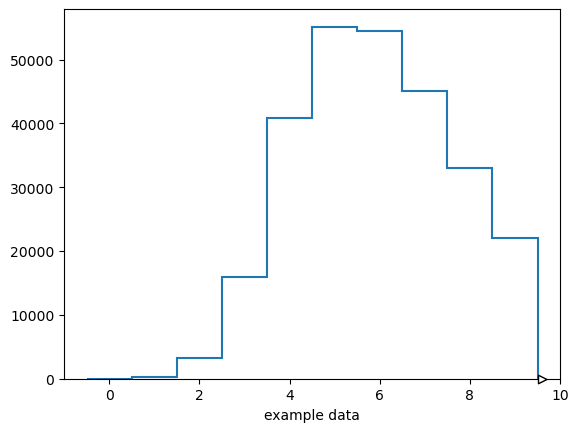

In [6]:
for dset,results in coutputs.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount']}")
    print(f"Test value: {results['Test']}")
    print(f"Other test value: {results['OtherTest']}")

coutputs["ZH_HToBB_ZToLL"]["MyHist"].plot()

## Running on a Cluster

This next cell gets you ready to run on Condor, including taking any specifications the user needs to make for the Condor cluster. To avoid issues, we also shut down the previous cluster, in case it did not close on its own. If it errors and says it was already closed, you can skip that cell.

If the environment you are running this in has the `cowtools` package installed, we will use that to create our cluster client, pre-configured to work with the Wisconsin AF's cluster. Otherwise, we'll make it by hand. Note that within this notebook, the very first cell detects whether or not `cowtools` is installed - by default, it should be installed whenever you use the Wisconsin AF.

If you are creating the cluster "by hand", make sure that the `"container_image"` classAd below matches the information given in `/container-info.yml`.

In [7]:
#If your environment has cowtools (it should), then this cell is really just one line
if HAS_COWTOOLS:
    client = cowtools.GetCondorClient(max_workers=MAX_WORKERS)
#The entire rest of this cell is only necessary if cowtools is not installed/not working
else:
    os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"
    
    try:
        _x509_localpath = (
            [
                line
                for line in os.popen("voms-proxy-info").read().split("\n")
                if line.startswith("path")
            ][0]
            .split(":")[-1]
            .strip()
        )
    except Exception as err:
        raise RuntimeError(
            "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
        ) from err
    _x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
    os.system(f"cp {_x509_localpath} {_x509_path}")
    _x509_path = os.path.basename(_x509_localpath)
    
    PWD = os.getcwd()
    print(f'Transferring contents of {PWD} to workers')
    INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
    cluster = HTCondorCluster(
        cores=1,
        memory="2 GB",
        disk="1 GB",
        death_timeout = '60',
        job_extra_directives={
            #"Requirements": 'Microarch != "x86_64-v2"',
            "+JobFlavour": '"tomorrow"',
            "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
            "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
            "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
            "should_transfer_files": "yes",
            "when_to_transfer_output": "ON_EXIT_OR_EVICT",
            "container_image": "/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask-almalinux8:2024.11.0-py3.11",
            "InitialDir": INITIAL_DIR,
            "transfer_input_files": f'{_x509_path}'
        },
        job_script_prologue=[
            "export XRD_RUNFORKHANDLER=1",
            f"export X509_USER_PROXY={_x509_path}",
        ]
    )
    print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
    cluster.adapt(minimum=1, maximum=MAX_WORKERS)
    client = Client(cluster)
    print("HTCondorCluster client created")

dask workers will run in /scratch/rsimeon/notebook.sif
Condor logs, output files, error files in /scratch/rsimeon


/usr/local/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 22427 instead
  warnings.warn(


In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/22427/status,
Dashboard: proxy/22427/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:4649,Workers: 0
Dashboard: proxy/22427/status,Total threads: 0
Started: Just now,Total memory: 0 B


The above cell should have produced a `Client` object, with a button that says "Launch dashboard in JupyterLab". Clicking that button will allow you to see the memory usage and worker status of your Condor workers in roughly real time.

The next cell again preprocesses our fileset and applies `ExampleAnalyzer`, but this time it runs distributed jobs on the cluster. You should be able to see your jobs moving in the dashboard, but it may take a few minutes. Running the jobs should finish in under 10 minutes.

In [9]:
with client, ProgressBar():
    print("About to preprocess")
    fileset_runnable, _ = preprocess(fileset)
    print("Finished preprocessing. Here is the pre-processed fileset:")
    #Run across the fileset
    outputs, reports = apply_to_fileset(ExampleAnalyzer,fileset_runnable,uproot_options={"allow_read_errors_with_report": True, "skipbadfiles": True, "timeout": 300})
    #Actually compute the outputs
    print("About to compute the outputs")
    coutputs_dist, creports_dist = dask.compute(outputs,reports)
    print("Finished computing outputs")

About to preprocess
[########################################] | 100% Completed | 101.94 ms
Finished preprocessing. Here is the pre-processed fileset:


/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/usr/local/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


About to compute the outputs
[########################################] | 100% Completed | 101.22 ms
Finished computing outputs


Again, we can look at the results.

Dataset: ggZH_HToBB_ZToLL
Event count: 14000
Dataset: ZH_HToBB_ZToLL
Event count: 300312


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2a7875a8d0>, errorbar=None, legend_artist=None)]

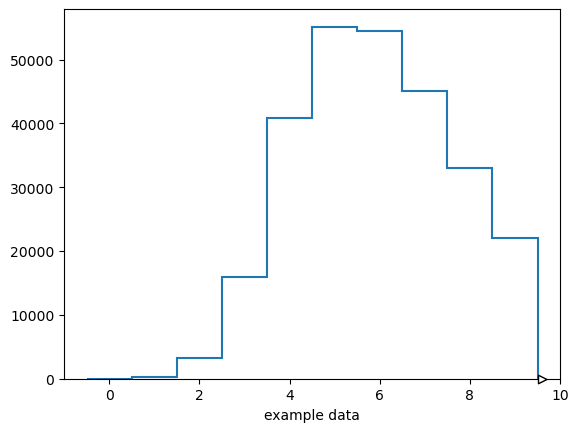

In [10]:
for dset,results in coutputs_dist.items():
    print(f"Dataset: {dset}")
    print(f"Event count: {results['EventCount']}")

coutputs_dist["ZH_HToBB_ZToLL"]["MyHist"].plot()

Finally, make sure to shut down your Condor client when you are done, just to avoid issues. If you forget, shutting down the notebook kernel also works.

In [11]:
client.shutdown()